In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/5cell_test"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np

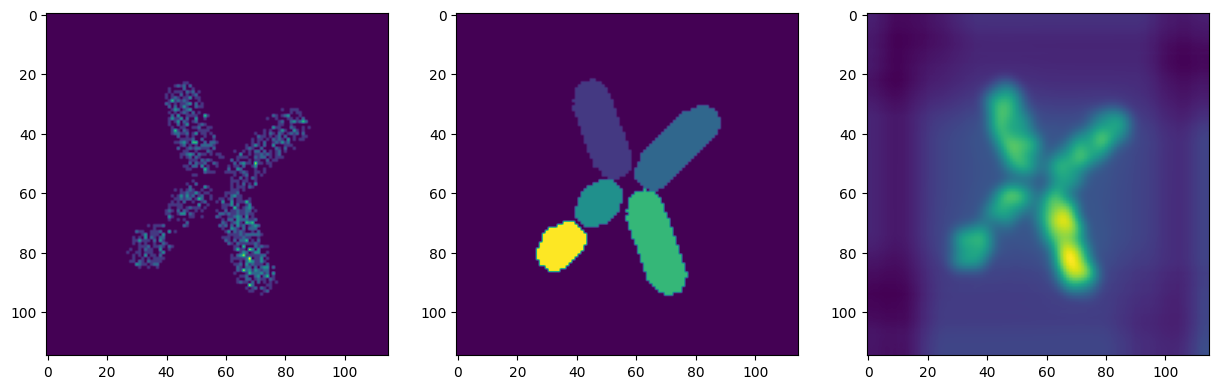

In [3]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [4]:
#Final all mid points of cells

min_x = {}
max_x = {}
min_y = {}
max_y = {}

(maskWidth, maskHeight) = mask.shape
print(maskWidth, maskHeight)

for i in range(maskWidth):
    for j in range(maskHeight):
        #Add mask value to dictionaries
        if (not mask[i][j] in min_x.keys()):
            min_x[mask[i][j]] = math.inf
            max_x[mask[i][j]] = -1
            min_y[mask[i][j]] = math.inf
            max_y[mask[i][j]] = -1
        
        min_x[mask[i][j]] = min(min_x[mask[i][j]],i)
        max_x[mask[i][j]] = max(max_x[mask[i][j]],i)
        min_y[mask[i][j]] = min(min_y[mask[i][j]],j)
        max_y[mask[i][j]] = max(max_y[mask[i][j]],j)

midpt = {}

for k in min_x.keys():
    midpt[k] = ((min_x[k]+max_x[k])/2,(min_y[k]+max_y[k])/2)

del(midpt[0.0])
print(midpt)


115 115
{1.5259022e-05: (38.5, 48.5), 3.0518044e-05: (45.0, 74.0), 4.5777066e-05: (63.5, 47.5), 6.103609e-05: (76.5, 67.0), 9.155413e-05: (78.0, 35.0)}


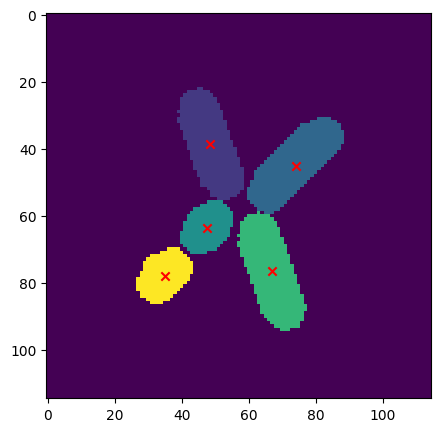

5


In [5]:
plt.imshow(mask)
for k in midpt:
    plt.scatter(midpt[k][1],midpt[k][0],color='red',marker='x')
plt.show()
print(len(midpt))

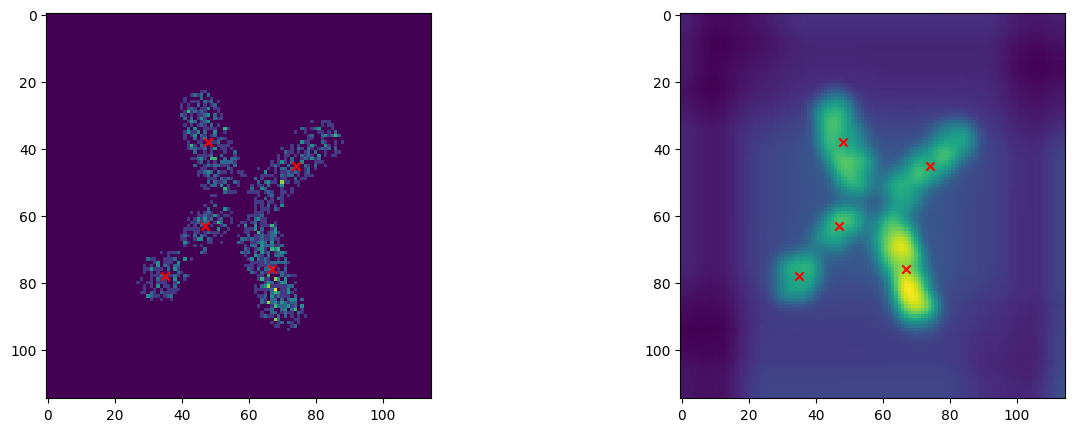

{1.5259022e-05: 1.2144935792502091e-05, 3.0518044e-05: 1.3390570232758716e-05, 4.5777066e-05: 1.4947613283079498e-05, 6.103609e-05: 1.9307333823977684e-05, 9.155413e-05: 1.3701978842822873e-05}
{1.5259022e-05: 41330.142857142855, 3.0518044e-05: 40365.71428571428, 4.5777066e-05: 41446.857142857145, 6.103609e-05: 53803.816326530614, 9.155413e-05: 39212.102040816324}


In [6]:
def AverageFilter(img, x, y):
    sz = [ -3, -2, -1, 0 , 1, 2, 3]
    total = 0
    for i in sz:
        for j in sz:
            total += img[x+i][y+j]
    total/=len(sz)*len(sz)
    return total

originalIntensity = {}
outputIntensity = {}


(originalWidth, originalHeight) = ori.shape
(outputWidth, outputHeight) = out.shape

f, axarr = plt.subplots(1,2)
axarr[0].imshow(ori)
axarr[1].imshow(out)
for k in midpt.keys():
    ratioX = midpt[k][0]/maskWidth
    ratioY = midpt[k][1]/maskHeight

    #Get intensity in original image
    originalX  = int(ratioX*originalWidth)
    originalY = int(ratioY*originalHeight)
    axarr[0].scatter(originalY,originalX,color='red',marker='x')

    originalIntensity[k] = AverageFilter(ori, originalX, originalY)

    #Get intensity in output image
    outputX  = int(ratioX*outputWidth)
    outputY = int(ratioY*outputHeight)
    axarr[1].scatter(outputY,outputX,color='red',marker='x')

    outputIntensity[k] = AverageFilter(out, outputX, outputY)

plt.show()

print(originalIntensity)
print(outputIntensity)
    

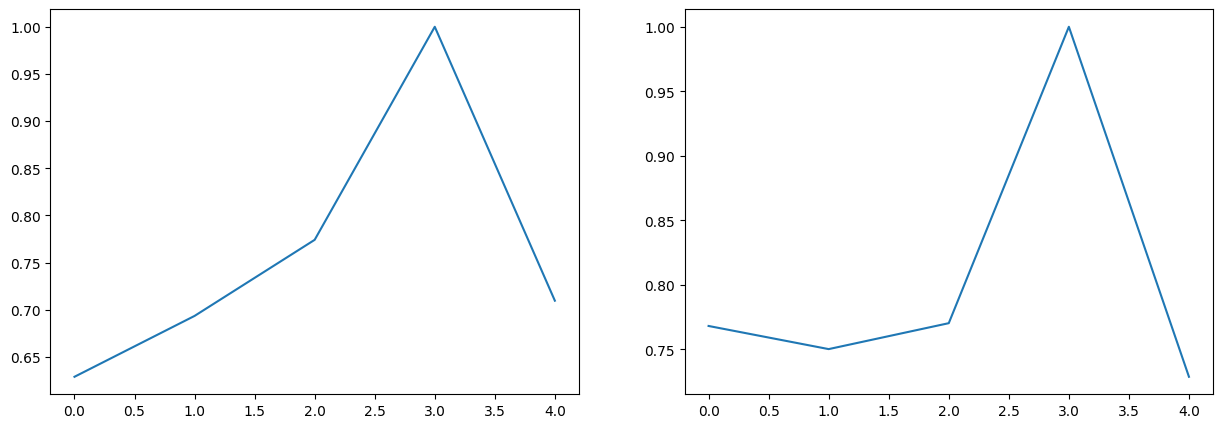

In [7]:
originalIntensityNp = np.asarray([originalIntensity[k] for k in originalIntensity.keys()])
outputIntensityNp = np.asarray([outputIntensity[k] for k in outputIntensity.keys()])

originalIntensityNp = originalIntensityNp / max(originalIntensityNp)
outputIntensityNp = outputIntensityNp / max(outputIntensityNp)

f, axarr = plt.subplots(1,2)
axarr[0].plot(originalIntensityNp)
axarr[1].plot(outputIntensityNp)
plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
def euclideanDistance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5

N = originalIntensityNp.shape[0]
distanceMatrix= []
intensityMatrix = []
midptKeys = list(midpt.keys())
maskSize = euclideanDistance(mask.shape,(0,0)) 

for idx in range(N):
    current = midpt[midptKeys[idx]]
    current = (int(current[0]),int(current[1]))
    distance = [euclideanDistance(midpt[midptKeys[k]],current)/maskSize for k in range(len(midptKeys))] #Normalise by diagonal length of mask
    intensty = [AverageFilter(out,current[0],current[1])/65535] #Normalise by max intensity
    distanceMatrix.append(torch.tensor(distance))
    intensityMatrix.append(torch.tensor(intensty))

#Include random points
for i in range(10*N):
    x = np.random.randint(0,maskWidth)
    y = np.random.randint(0,maskHeight)
    try:
        distance = [euclideanDistance(midpt[midptKeys[k]],(x,y))/maskSize for k in range(len(midptKeys))]
        intensty = [AverageFilter(out,x,y)/65535]
        distanceMatrix.append(torch.tensor(distance))
        intensityMatrix.append(torch.tensor(intensty))
    except:
        pass

#Convert to tensor
distanceMatrix = torch.stack(distanceMatrix)
intensityMatrix = torch.stack(intensityMatrix)

In [10]:
#Create custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, distanceMatrix, intensityMatrix):
        self.distanceMatrix = distanceMatrix
        self.intensityMatrix = intensityMatrix
    def __len__(self):
        return len(self.intensityMatrix)

    def __getitem__(self, idx):
        return (self.distanceMatrix[idx], self.intensityMatrix[idx]) 
dataset = CustomDataset(distanceMatrix, intensityMatrix)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

In [11]:
class Net(nn.Module):
    def __init__(self,N):
        super(Net, self).__init__()
        self.polynomial_degree = 20
        self.polynomial_weights = nn.Linear(self.polynomial_degree,1,bias=False)
        self.polynomial_weights.weight.data[0][0] = -150
        self.actual_intensity = nn.Linear(N,1,bias=False)

    def forward(self, x):
        stack = []
        for i in range (1, self.polynomial_degree+1):
            stack.append(torch.pow(x,2*i))
        x = torch.stack(stack, dim=2)
        x = self.polynomial_weights(x)
        x = x.reshape(x.shape[0],x.shape[1])
        x = torch.exp(x)
        x = self.actual_intensity(x)
        return x

model = Net(N)
model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
#model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD([
                    {'params': model.polynomial_weights.parameters(), 'lr': 0.1},
                    {'params': model.actual_intensity.parameters(), 'lr': 0.001}
                ], lr=0.001, momentum=0.9)


In [12]:
#Training loop
for epoch in range(200):  # loop over the dataset multiple times
    print("Epoch: ",epoch+1)
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        model.zero_grad()
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data
        # forward + backward + optimize
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        loss.backward()
        optimizer.step()
        model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
        #model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial
        # print statistics
        running_loss += loss.item()
    print("Loss: ",running_loss)
print('Finished Training')


Epoch:  1
Loss:  0.4650473967194557
Epoch:  2
Loss:  0.4542352892458439
Epoch:  3
Loss:  0.4595599099993706
Epoch:  4
Loss:  0.4720607362687588
Epoch:  5
Loss:  0.44944545812904835
Epoch:  6
Loss:  0.4386101979762316
Epoch:  7
Loss:  0.43782472610473633
Epoch:  8
Loss:  0.44171176850795746
Epoch:  9
Loss:  0.4369565602391958
Epoch:  10
Loss:  0.4484588988125324
Epoch:  11
Loss:  0.4308178797364235
Epoch:  12
Loss:  0.41924682073295116
Epoch:  13
Loss:  0.42006421834230423
Epoch:  14
Loss:  0.4157620891928673
Epoch:  15
Loss:  0.44050829857587814
Epoch:  16
Loss:  0.45405686646699905
Epoch:  17
Loss:  0.4110532980412245
Epoch:  18
Loss:  0.4258750844746828
Epoch:  19
Loss:  0.4502155799418688
Epoch:  20
Loss:  0.3972026854753494
Epoch:  21
Loss:  0.39636667631566525
Epoch:  22
Loss:  0.3935312535613775
Epoch:  23
Loss:  0.4345615319907665
Epoch:  24
Loss:  0.39240981824696064
Epoch:  25
Loss:  0.388035686686635
Epoch:  26
Loss:  0.3825829979032278
Epoch:  27
Loss:  0.38079901970922947
E

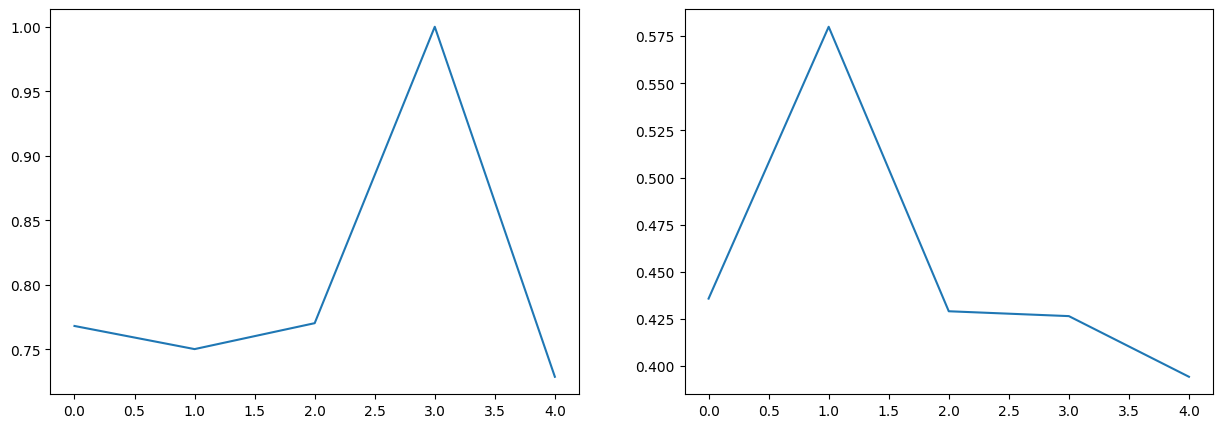

In [13]:
#Check model's output intenstiy against original intensity

modelIntensityNp = model(distanceMatrix[:N]).detach().numpy()
f, axarr = plt.subplots(1,2)
axarr[0].plot(outputIntensityNp)
axarr[1].plot(modelIntensityNp)
plt.show()


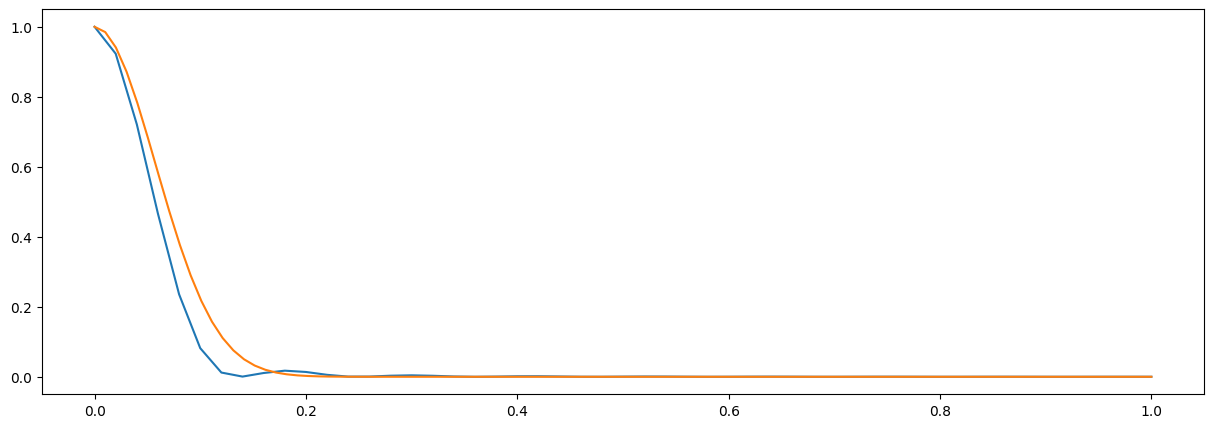

In [14]:
#Checks our model's psf against original psf

with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)

#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)


coeff = model.polynomial_weights.weight.data[0]
bias = 0
                                          
def getPSF(x, coeff, bias):
    total = bias
    for i in range(len(coeff)):
        total += coeff[i]*(x**(2*(i+1)))
    return torch.exp(total)

new_psf_x = np.linspace(0,1,100)
new_psf_y = getPSF(new_psf_x, coeff, bias)
plt.plot(new_psf_x,new_psf_y.detach().numpy())
plt.show()


tensor(0.0436, dtype=torch.float64)


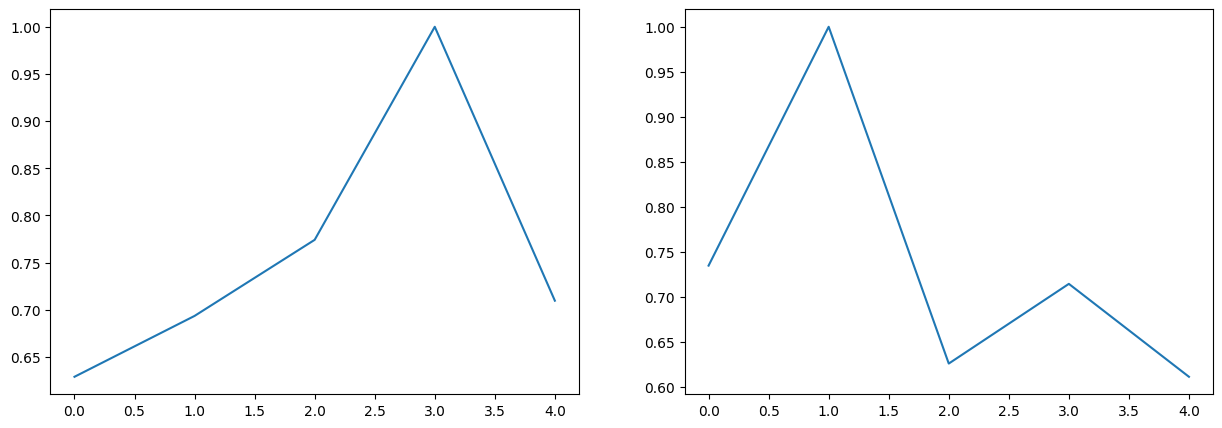

In [15]:
#Checks our model's intensity against original intensity

model_intensity = model.actual_intensity.weight.data.detach().numpy()[0]
model_intensity = model_intensity / max(model_intensity)
print(criterion(torch.tensor(model_intensity),torch.tensor(originalIntensityNp)))
f, axarr = plt.subplots(1,2)
axarr[0].plot(originalIntensityNp)
axarr[1].plot(model_intensity)
plt.show()


-0.19929580550627776


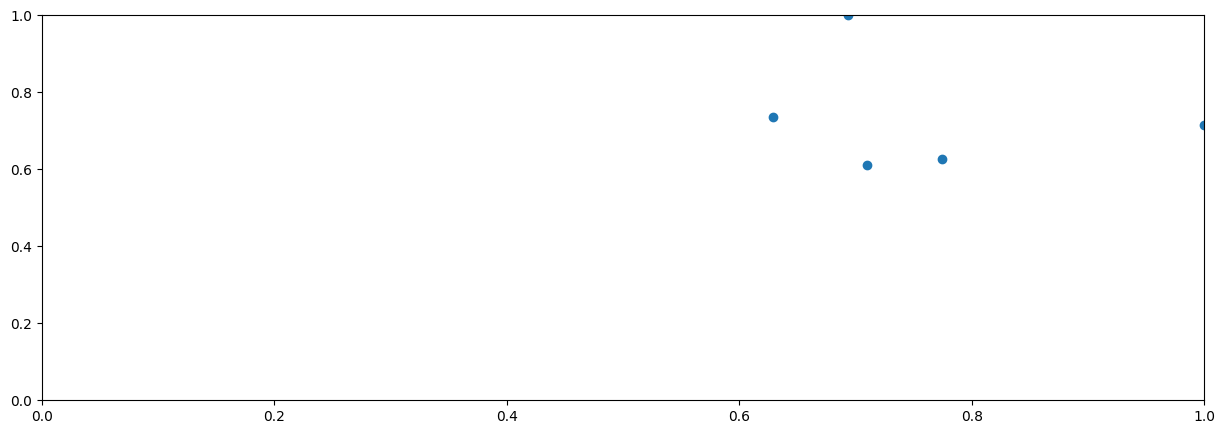

In [16]:
plt.plot(originalIntensityNp,model_intensity,'o')
plt.xlim(0,1)
plt.ylim(0,1)
#calculate correlation coefficient
print(np.corrcoef(model_intensity,originalIntensityNp)[0,1])
plt.show()

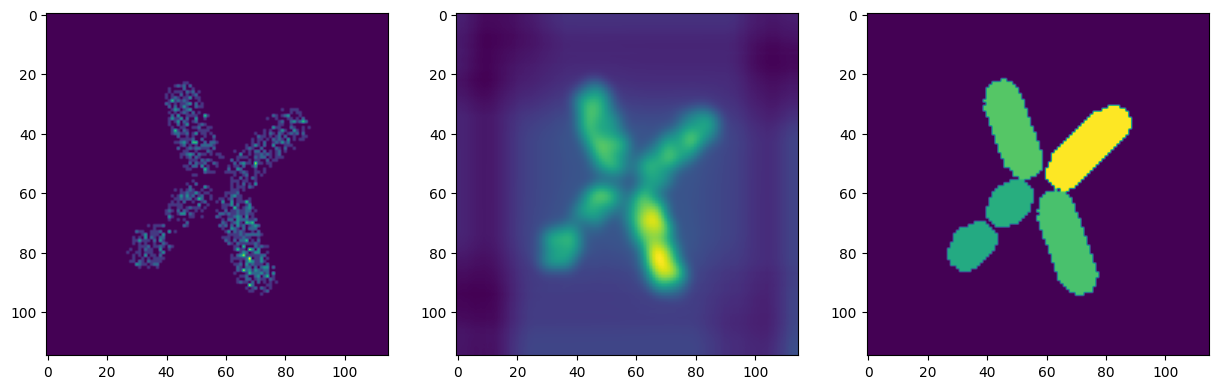

In [17]:
#Recreate original image based off of calculated intensity

customOriginal = mask.copy()
maskToNewIntensity = {}
maskToNewIntensity[0.0] = 0.0
for i in range(len(midptKeys)):
    maskToNewIntensity[midptKeys[i]] = model_intensity[i]
for x in range(len(customOriginal)):
    for y in range(len(customOriginal[0])):
        customOriginal[x][y] = maskToNewIntensity[customOriginal[x][y]]

oriNormalised = np.asanyarray(ori)
oriNormalised = oriNormalised / max(oriNormalised.flatten())

outNormalised = np.asanyarray(out)
outNormalised = outNormalised / max(outNormalised.flatten())

customOriginal = customOriginal / max(customOriginal.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(oriNormalised)
axarr[1].imshow(outNormalised)
axarr[2].imshow(customOriginal)
plt.show()
